# Install and Load Libraries/Data

In [98]:
#!pip install skorch

In [99]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib

In [100]:
# Paths to data folders
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Splitting and Preprocessing of Parquet Columns

In [101]:
# Drop columns with NaNs in train_df
#train_df.dropna(axis=1, inplace=True)

# Drop columns with NaNs in test_df
#test_df.dropna(axis=1, inplace=True)

In [102]:
# Separate features and target
X_train = train_df.drop(columns=['id', 'sii'])
y_train = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

X_test = test_df.drop(columns=['id'])
y_test = None

In [103]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [104]:
# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    # Impute missing values with mean
    ('scaler', StandardScaler())                    # Scale features
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encode
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [105]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU()):
        super().__init__()
        # Define hidden layers
        self.hidden = nn.ModuleList()
        layer_sizes = [inp_size] + hidden_sizes + [num_classes]
        for i in range(len(layer_sizes) - 1):
            self.hidden.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                self.hidden.append(nonlin)

    def forward(self, X):
        for layer in self.hidden:
            X = layer(X)
        return X

In [106]:
# Determine the number of input features after preprocessing
# Fit the preprocessor first to get the transformed feature count
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train).shape[1]

# Define the Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],            
    max_epochs=20,
    lr=0.001,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.CrossEntropyLoss,
    batch_size=256,
    iterator_train__shuffle=True,
    verbose=0,                                 
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

In [107]:
params = {
    'nn__lr': [0.01, 0.001],
    'nn__max_epochs': [10, 20],
    'nn__module__hidden_sizes': [[128, 64], [64, 32]],
    'nn__module__nonlin': [nn.ReLU(), nn.Tanh()],
}

In [108]:
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=10,                      # 10-fold cross-validation
    scoring='accuracy',          # Use roc_auc as the scoring metric
    refit=True,                 # Refit the model with the best parameters
    verbose=2,                  # Verbosity level
    n_jobs=-1                   # Utilize all available cores
)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'Basic_Demos-Sex',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physical-Heart...
                                        FunctionTransformer(func=<function <lambda> at 0x000002B7B105A340>)),
                                       ('nn',
                                        <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MyModule'>,
  module__hidden_sizes=[128, 64],
  module__inp_size=148,
))]),
             n_jobs=-1,
             param_grid={'nn__lr': [0.01, 0.001], 'nn__max_epochs': [10, 20],
                         'nn__module__hidden_sizes': [[128, 64], [64, 32]],
                         'nn__module__nonlin': [ReLU(), Tanh()]},
             scoring='accuracy', verbose=2)

# Evaluating Skorch NN

In [109]:
# Print best score and parameters
print(f"\nBest Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")

best_pipeline = gs.best_estimator_


Best Validation Accuracy: 0.9667
Best Parameters: {'nn__lr': 0.01, 'nn__max_epochs': 20, 'nn__module__hidden_sizes': [128, 64], 'nn__module__nonlin': Tanh()}


In [110]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=22,
    stratify=y_train
)

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9874

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       563
           1       0.96      0.97      0.97       146
           2       0.97      0.99      0.98        76
           3       1.00      1.00      1.00         7

    accuracy                           0.99       792
   macro avg       0.98      0.99      0.99       792
weighted avg       0.99      0.99      0.99       792



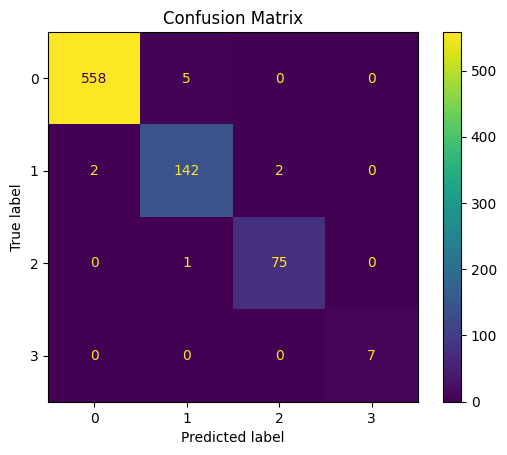

In [111]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()